In [1]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import warnings
warnings.filterwarnings('ignore')

# File Tools for local
import pandas as pd
import sys

# Random seed for reproducibility
import random

import torch
# from botorch.models.gp_regression import HeteroskedasticSingleTaskGP - This was removed in path #2616.
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.gp_regression_mixed import MixedSingleTaskGP
from botorch.acquisition import qExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from botorch.models import MixedSingleTaskGP
from botorch.optim import optimize_acqf_mixed


from ipywidgets import interact, FloatSlider

#LHS sampling
#from pyDOE import lhs
from smt.sampling_methods import LHS
import random

# Cluster 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


>## Data Prep

In [2]:
df = pd.read_csv('parameterspace.csv')
df

,n,theta,r,t,toughness,mass,printerid,campaignid,category
0,6,0,1.5,0.70,1.144667,1.7131,1,1,2
1,6,0,1.5,1.05,1.607561,1.9386,2,1,2
2,6,0,1.5,1.40,1.144338,1.9828,3,1,2
3,6,0,1.7,0.70,3.642738,1.9723,4,1,2
4,6,0,1.7,1.05,3.748405,2.2785,5,1,2
...,...,...,...,...,...,...,...,...,...
1795,12,200,2.3,1.05,1.358975,6.3430,5,3,3
1796,12,200,2.3,1.40,3.196306,5.7742,1,3,3
1797,12,200,2.5,0.70,36.104187,4.8745,2,3,3
1798,12,200,2.5,1.05,1.313487,6.7221,4,3,3


In [3]:
x_inputs = df[['n',	'theta','r','t'] ]
y_outputs = df["toughness"]
# Set the device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
# Convert to torch tensors
x_all = torch.tensor(x_inputs.to_numpy(), dtype=torch.float32)
y_all = torch.tensor(y_outputs.values.reshape(-1, 1), dtype=torch.float32)
print(y_all.max())

def ground_truth_pool(x_query_batch):
    x_query_batch = x_query_batch[['n', 'theta', 'r', 't']]
    x_pool = x_inputs[['n', 'theta', 'r', 't']].to_numpy()

    # Compute pairwise differences with broadcasting
    A = x_pool[:, None, :]         # (1800, 1, 4)
    B = x_query_batch.to_numpy()[None, :, :]  # (1, 6, 4)
    diffs = A - B                  # (1800, 6, 4)
    dists = np.linalg.norm(diffs, axis=2)  # (1800, 6)

    # For each query point, find the closest in x_pool
    min_indices = dists.argmin(axis=0)  # (6,)
    return x_all[min_indices], y_all[min_indices]



tensor(51.5426)


In [4]:
## Build Model A class 
class GaussianModelC:
    def __init__(self, x_train, y_train, y_train_var,bounds):
        self.x_train = x_train
        self.y_train = y_train
        self.y_train_var = y_train_var
        self.bounds = bounds
        self.model = self._fit_gp_model()
        self.model_mixed = self._fit_gp_mixed_model()
    
    def _fit_gp_model(self):
        model = SingleTaskGP(self.x_train, self.y_train,self.y_train_var)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)
        return model
    
    def _fit_gp_mixed_model(self):
        model_mixed = MixedSingleTaskGP(self.x_train, self.y_train,cat_dims=[1],train_Yvar=self.y_train_var)
        mll = ExactMarginalLogLikelihood(model_mixed.likelihood, model_mixed)
        fit_gpytorch_mll(mll)
        return model_mixed

    def gp_evaluate(self, test_x):
        self.model.eval()
        with torch.no_grad():
            posterior = self.model.posterior(test_x)
        mean = posterior.mean.squeeze().numpy()
        var = posterior.variance.squeeze().numpy()
        return mean, var

    def optimize_ei(self, batch_size=3):
        self.best_f = self.y_train.max()
        qEI = qExpectedImprovement(model=self.model, best_f=self.best_f)
        candidate, _ = optimize_acqf(
            acq_function=qEI,
            bounds=torch.tensor([[0., 0., 0. , 0.], [1., 1., 1.,1.]], dtype=self.x_train.dtype),
            q=batch_size,
            num_restarts=15,
            raw_samples=100,
        )
        return unnormalize(candidate, self.bounds)
    
    def optimize_mixed(self, fixed_feature_list, batch_size=6):
        self.best_f = self.y_train.max()
        qEI = qExpectedImprovement(model=self.model_mixed , best_f=self.best_f)
        
        candidate_mixed, _ = optimize_acqf_mixed(
        acq_function=qEI,
        bounds=torch.tensor([[0., 0., 0. , 0.], [1., 1., 1.,1.]], dtype=dtype, device=device),
        q=batch_size,
        fixed_features_list=fixed_feature_list,
        num_restarts=10,
        raw_samples=15,
        options={"dtype": dtype, "device": device}
        )
        return unnormalize(candidate_mixed, self.bounds)
        
        
    def optimize_acqf_data(self, X_candidates, batch_size=6):
        self.best_f = self.y_train.max()
        qEI = qExpectedImprovement(model=self.model, best_f=self.best_f)

        with torch.no_grad():
            acq_values = qEI(X_candidates.unsqueeze(1))  # shape (N, 1)

        top_indices = torch.topk(acq_values.squeeze(-1), batch_size,largest=True).indices
        batch_x = X_candidates[top_indices]
        return unnormalize(batch_x ,self.bounds) # shape (batch_size, d)
    
    
    def new_candidates(self,feature='theta'):
        candidates_4D = self.optimize_ei().cpu().numpy()  # <-- fix is here
        # Create a DataFrame with the candidates
        data = {
            'n': candidates_4D[:, 0],
            'theta': candidates_4D[:, 1],
            'r': candidates_4D[:, 2],
            't': candidates_4D[:, 3]
        }
        data_df = pd.DataFrame(data)
        constraints = np.array(data_df[feature].values)

        discrete_choices = normalize(torch.tensor(constraints),self.bounds[:,1])
        fixed_features_list = [{1: float(discrete_choices[0])},{1: float(discrete_choices[1])},{1: float(discrete_choices[2])}]

        candidates_mixed = self.optimize_mixed(fixed_feature_list=fixed_features_list)

        data_mix = {
            'n': candidates_mixed[:, 0],
            'theta': candidates_mixed[:, 1],
            'r': candidates_mixed[:, 2],
            't': candidates_mixed[:, 3]
        }
        data_mix_df = pd.DataFrame(data_mix)
        

        return data_mix_df.round(2)

class Plotting:
    def __init__(self, gp_model:GaussianModelC, variable_combinations):
        self.gp_model = gp_model
        self.x_train = gp_model.x_train
        self.y_train = gp_model.y_train
        self.bounds = gp_model.bounds
        self.model = gp_model.model
        self.variable_combinations = variable_combinations
        self.dtype = dtype

    def generate_input_data(self, A, B, c, d, combination):
        if combination == ('n', 'r', 't'):
            return torch.tensor(np.array([[A[i, j], d, B[i, j], c] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=self.dtype)
        elif combination == ('theta', 'r', 't'):
            return torch.tensor(np.array([[d, A[i, j], B[i, j], c] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=self.dtype)
        elif combination == ('n', 't', 'theta'):
            return torch.tensor(np.array([[A[i, j], c, B[i, j], d] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=self.dtype)

    def create_slices(self, c_slices, d_fixed, combination):
        num_points = 20
        a = np.linspace(0, 1, num_points)
        b = np.linspace(0, 1, num_points)
        A, B = np.meshgrid(a, b)

        store_mean = []
        for d in d_fixed:
            mean_values = []
            for c in c_slices:
                input_data = self.generate_input_data(A, B, c, d, combination)
                mean, _ = self.gp_model.gp_evaluate(input_data)
                mean_values.append(mean.reshape(A.shape))  # Reshape to grid
            store_mean.append(mean_values)

        return A, B, store_mean
    

    def sliced_plotting(self, combination, minmax, colormap='Viridis'):
        # Create slices for the fixed variable
        c_slices = np.linspace(0, 1, 12)
        d_fixed = [0, 0.25, 0.5, 0.75, 1.0]  # Fixed value for the other variable

        # Create a new figure with subplots for each combination
        fig = make_subplots(rows=1, cols=5, subplot_titles=('theta: 0', 'theta: 0.25','theta: 0.5', 'theta: 0.75','theta: 1.0'),
                        specs=[[{'type': 'surface'}, {'type': 'surface'},{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]])
        global_min = minmax[0].item()
        global_max = minmax[1].item()

        # Create slices and get mean values
        A, B, store_mean = self.create_slices(c_slices, d_fixed, combination)
        # Unpack the mean values for each slice
        mean_vals1, mean_vals2, mean_vals3, mean_vals4, mean_vals5 = store_mean[0], store_mean[1], store_mean[2], store_mean[3], store_mean[4]  

        for i, (c, y_grid1, y_grid2, y_grid3, y_grid4, y_grid5) in enumerate(zip(c_slices, mean_vals1,mean_vals2,mean_vals3,mean_vals4,mean_vals5), start=1):
            fig.add_trace(go.Surface(
                x=A,
                y=B,
                z=c * np.ones_like(A),  # Z-coordinate for slicing
                surfacecolor=y_grid1,  # Use predicted `y` as contour
                colorscale=colormap,
                cmin=global_min,
                cmax=global_max,
                showscale=True if i == 1 else False,  # Show color scale only on the first slice
                #   colorbar_x=0.45,
                opacity=0.7
            ), row=1, col=1)
    
            fig.add_trace(go.Surface(
                x=A,
                y=B,
                z=c * np.ones_like(A),  # Z-coordinate for slicing
                surfacecolor=y_grid2,  # Use predictediance as contour
                cmin=global_min,
                cmax=global_max,
                colorscale=colormap,
                showscale=True if i == 1 else False,  # Show color scale only on the first slice
                #colorbar_x=0.45,
                opacity=0.7
            ), row=1, col=2)

            fig.add_trace(go.Surface(
                x=A,
                y=B,
                z=c * np.ones_like(A),  # Z-coordinate for slicing
                surfacecolor=y_grid3,  # Use predictediance as contour
                cmin=global_min,
                cmax=global_max,
                colorscale=colormap,
                showscale=True if i == 1 else False,  # Show color scale only on the first slice
                opacity=0.7
            ), row=1, col=3)

            fig.add_trace(go.Surface(
                x=A,
                y=B,
                z=c * np.ones_like(A),  # Z-coordinate for slicing
                surfacecolor=y_grid4,  # Use predictediance as contour
                cmin=global_min,
                cmax=global_max,
                colorscale=colormap,
                showscale=True if i == 1 else False,  # Show color scale only on the first slice
                opacity=0.7
            ), row=1, col=4)

            fig.add_trace(go.Surface(
                x=A,
                y=B,
                z=c * np.ones_like(A),  # Z-coordinate for slicing
                surfacecolor=y_grid5,  # Use predictediance as contour
                cmin=global_min,
                cmax=global_max,
                colorscale=colormap,
                showscale=True if i == 1 else False,  # Show color scale only on the first slice
                opacity=0.7
            ), row=1, col=5)
            
        fig.update_layout(
            height=400,
            width=1300,
            margin=dict(l=50, r=50, b=50, t=50),
            scene=dict(
                xaxis_title=combination[0],
                yaxis_title=combination[1],
                zaxis_title=combination[2]
            ),
            scene2=dict(
                xaxis_title=combination[0],
                yaxis_title=combination[1],
                zaxis_title=combination[2]
            ),
            scene3=dict(
                xaxis_title=combination[0],
                yaxis_title=combination[1],
                zaxis_title=combination[2]
            ),
            scene4=dict(
                xaxis_title=combination[0],
                yaxis_title=combination[1],
                zaxis_title=combination[2]
            ),
            scene5=dict(
                xaxis_title=combination[0],
                yaxis_title=combination[1],
                zaxis_title=combination[2]
            )
        )

        fig.show()

def find_matching_rows(new_candidates, x_inputs):
    matching_id = []
    for i in range(len(new_candidates)):
        # Define the row to match
        row_to_match = new_candidates.iloc[i].to_numpy().round(2)

        # Find the index of the matching row
        matching_index = x_inputs[(x_inputs['n'] == row_to_match[0]) &
                                (x_inputs['theta'] == row_to_match[1]) &
                                (x_inputs['r'] == row_to_match[2]) &
                                (x_inputs['t'] == row_to_match[3])].index
        matching_id.append(matching_index.tolist())
    return matching_id

def find_nearest_rows(new_candidates, x_query_df, columns=['n', 'theta', 'r', 't']):
    """
    For each row in x_query_df, find the closest row in new_candidates using Euclidean distance.
    Both inputs are pandas DataFrames with matching columns.
    """
    x_pool = new_candidates[columns].to_numpy()
    x_query = x_query_df[columns].to_numpy()

    nearest_indices = []

    for xq in x_query:
        # Compute distances to all pool points
        dists = np.linalg.norm(x_pool - xq, axis=1)
        nearest_idx = np.argmin(dists)
        nearest_indices.append(nearest_idx)

    return nearest_indices
    
def ground_truth_value(matching_id):
    y_means = []
    y_vars = []
    for i in range(len(matching_id)):
        y_mean = np.array(y_all[matching_id[i]]).mean()
        y_var = np.array(y_all[matching_id[i]]).var()
        #print("Mean:", y_mean)
        y_means.append(y_mean)
        y_vars.append(y_var)
    return torch.tensor(y_means).reshape(-1,1), torch.tensor(y_vars).reshape(-1,1)




>## Initial Sampling Step

In [5]:
bounds = torch.tensor([[x_all[:, 0].min(), x_all[:, 0].max()],
                      [x_all[:, 1].min(), x_all[:, 1].max()],
                      [x_all[:, 2].min(), x_all[:, 2].max()],
                      [x_all[:, 3].min(), x_all[:, 3].max()]], dtype=torch.float32)

#bounds = torch.tensor([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]], dtype=torch.float32)

# Lets say theta is constrained 
# Bounds : sulf , anly, temp, time
xlimits = bounds.numpy()
sampling = LHS(xlimits=xlimits,random_state = np.random.RandomState(0))

num = 6
x = sampling(num)

lhs_data = pd.DataFrame(x, columns=['n','theta','r','t'])
# print(lhs_data.round(2))

# Select the 'temp' column for clustering
constrained = lhs_data[['theta']]

# Standardize the data (important for K-Means)
scaler = StandardScaler()
temp_data_scaled = scaler.fit_transform(constrained )

# Choose the number of clusters
num_clusters = 3

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, n_init=100, random_state=42)
lhs_data['cluster'] = kmeans.fit_predict(temp_data_scaled)

# Get cluster assignments and centroids
cluster_assignments = kmeans.labels_

# Get the centroids
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# Display the centroids
print("Centroids of theta Clusters:")
print(centroids)

# Replace the theta values in lhs_data with the centroid temperatures for the designated clusters
for cluster in range(num_clusters):
    lhs_data.loc[lhs_data['cluster'] == cluster, 'theta'] = centroids[cluster][0]

# Display the updated lhs_data
print(lhs_data.round(2).drop(columns=['cluster']))


Centroids of theta Clusters:
[[166.66666667]
 [ 33.33333333]
 [100.        ]]
      n   theta     r     t
0  11.5  100.00  1.75  1.11
1   8.5   33.33  2.08  0.99
2   9.5  166.67  1.58  0.87
3  10.5  166.67  2.42  1.34
4   7.5  100.00  2.25  0.76
5   6.5   33.33  1.92  1.22


In [6]:
original_bounds = torch.tensor([[x_all[:,0].min(), x_all[:,1].min(), x_all[:,2].min(), x_all[:,3].min()], [x_all[:,0].max(), x_all[:,1].max(), x_all[:,2].max(), x_all[:,3].max()]])
random.seed(42)
random_indices = random.sample(range(x_all.shape[0]), 10)
x_train, _ = ground_truth_pool(lhs_data)
nx_train = normalize(x_train, bounds=original_bounds) # normalized data for training

x_train_df = pd.DataFrame(x_train.numpy(), columns=['n', 'theta', 'r', 't']) # Converted dataframe of the training data
matching_index = find_nearest_rows(x_inputs,x_train_df) # THe cloeset indecies
y_train,y_train_var = ground_truth_value(matching_index) # Train_y and train y var. Variance exists is multiple of the same rows exist

nx_all = normalize(x_all,original_bounds)

# Step 1: Initialize your model
gp_model = GaussianModelC(x_train=nx_train, y_train=y_train, y_train_var=y_train_var, bounds=original_bounds)

# Step 2: Initialize Plotting class
variable_combinations = [('n', 'r', 't'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_model, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
plotting.sliced_plotting(combination, minmax)

In [7]:
def BO_loop(gp_model,train_nx, train_y,train_yvar, nx_all,iterations=5):
    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.new_candidates(feature='theta')

        # Remove new_candidates from x_all
        x_all_new = nx_all.numpy()
        new_candidates_np = new_candidates[['n', 'theta', 'r', 't']].to_numpy()
        mask = ~np.isin(x_all_new, new_candidates_np).all(axis=1)
        x_all_new = torch.tensor(x_all_new[mask], dtype=torch.float32)

        matching_index = find_nearest_rows(x_inputs,new_candidates) # THe cloeset indecies
       
        x_train = torch.tensor(x_all[matching_index], dtype=torch.float32)
        nx_train = normalize(x_train, bounds=original_bounds)
        y_train ,y_train_var = ground_truth_value(matching_index) # Train_y and train y var. Variance exists is multiple of the same rows exist

        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_train), dim=0)
        train_y = torch.cat((train_y, y_train), dim=0)
        train_yvar = torch.cat((train_yvar, y_train_var), dim=0)

        # Step 1: Instantiate and train model
        gp_model = GaussianModelC(x_train = train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds)

    return gp_model, train_nx, train_y, train_yvar


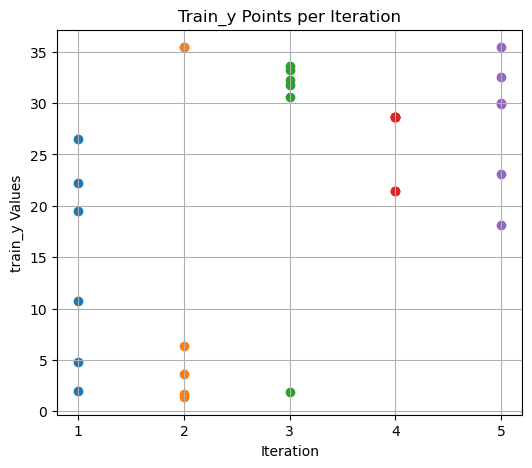

Iteration 1: tensor([26.5537])
Iteration 2: tensor([35.4450])
Iteration 3: tensor([33.5952])
Iteration 4: tensor([28.6198])
Iteration 5: tensor([35.4450])


In [8]:
gp_model5, train_nx5, train_y5, train_yvar5 = BO_loop(gp_model, nx_train, y_train, y_train_var, nx_all, iterations=5)

train_x5 = unnormalize(train_nx5, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('n', 'r', 't'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_model5, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
plotting.sliced_plotting(combination, minmax)

# Split train_y into 5 iterations, each containing 5 points
iterations = 5
points_per_iteration = 6
split_data = [train_y5[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]
split_datax = [train_y5[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('Train_y Points per Iteration')
plt.xticks(range(1, iterations + 1))
# plt.legend()
plt.grid(True)
plt.show()

argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")


In [9]:
top_10_indices = torch.topk(y_all.squeeze(), 10).indices
x_all[top_10_indices], y_all[top_10_indices]

(tensor([[ 12.0000, 200.0000,   1.7000,   1.4000],
         [ 12.0000,  25.0000,   2.4000,   0.7000],
         [ 12.0000,  25.0000,   2.4000,   0.7000],
         [ 12.0000, 150.0000,   1.9000,   1.4000],
         [ 12.0000, 150.0000,   1.9000,   1.4000],
         [ 10.0000, 200.0000,   1.7000,   1.4000],
         [ 12.0000, 175.0000,   1.8000,   1.4000],
         [ 10.0000, 200.0000,   1.7000,   1.4000],
         [ 12.0000,  75.0000,   2.4000,   1.0500],
         [ 12.0000,  75.0000,   2.4000,   1.0500]]),
 tensor([[51.5426],
         [50.8313],
         [50.2935],
         [49.2508],
         [48.9871],
         [48.0643],
         [48.0047],
         [47.6848],
         [47.3057],
         [46.9209]]))

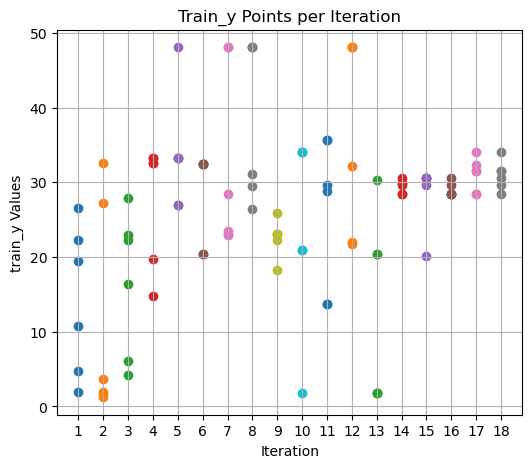

Iteration 1: tensor([  8.0000, 100.0000,   2.3000,   0.7000])
Iteration 2: tensor([ 10.0000, 200.0000,   2.5000,   0.7000])
Iteration 3: tensor([12.0000, 50.0000,  2.1000,  1.0500])
Iteration 4: tensor([ 10.0000, 200.0000,   2.3000,   0.7000])
Iteration 5: tensor([ 10.0000, 200.0000,   1.7000,   1.4000])
Iteration 6: tensor([ 10.0000, 200.0000,   1.5000,   1.4000])
Iteration 7: tensor([ 10.0000, 200.0000,   1.7000,   1.4000])
Iteration 8: tensor([ 10.0000, 200.0000,   1.7000,   1.4000])
Iteration 9: tensor([ 10.0000, 175.0000,   1.6000,   1.0500])
Iteration 10: tensor([ 12.0000, 175.0000,   1.6000,   1.0500])
Iteration 11: tensor([ 12.0000, 150.0000,   1.7000,   1.0500])
Iteration 12: tensor([ 10.0000, 200.0000,   1.7000,   1.4000])
Iteration 13: tensor([ 12.0000, 150.0000,   2.1000,   0.7000])
Iteration 14: tensor([ 12.0000, 150.0000,   1.9000,   0.7000])
Iteration 15: tensor([ 12.0000, 150.0000,   1.9000,   0.7000])
Iteration 16: tensor([ 12.0000, 150.0000,   1.9000,   0.7000])
Itera

In [10]:
gp_model18, train_nx18, train_y18, train_yvar18 = BO_loop(gp_model, nx_train, y_train, y_train_var, nx_all, iterations=18)

train_x18 = unnormalize(train_nx18, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('n', 'r', 't'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_model18, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
plotting.sliced_plotting(combination, minmax)

# Split train_y into 18 iterations, each containing 18 points
iterations = 18
points_per_iteration = 6
split_data = [train_y18[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]
split_datax = [train_x18[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('Train_y Points per Iteration')
plt.xticks(range(1, iterations + 1))
# plt.legend()
plt.grid(True)
plt.show()
argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")